In [1]:
%load_ext jupyternotify

import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import TSPN
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import shot_solvers as SHOT

import sim_template as sim
from importlib import reload 

<IPython.core.display.Javascript object>

In [2]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


[15.5, 47.0] [34.5, 47.0]
[1.1974411167423504, 27.772758664047835] [10.697441116742354, 44.227241335952165]
[10.697441116742345, 5.772758664047837] [1.1974411167423495, 22.227241335952172]
[34.5, 2.9999999999999982] [15.499999999999996, 3.0000000000000004]
[48.802558883257646, 22.227241335952154] [39.30255888325764, 5.772758664047824]
[39.302558883257646, 44.227241335952165] [48.802558883257646, 27.772758664047835]
0.0625
[2.4, 2.4, 2.4, 2.4, 2.4, 2.4]


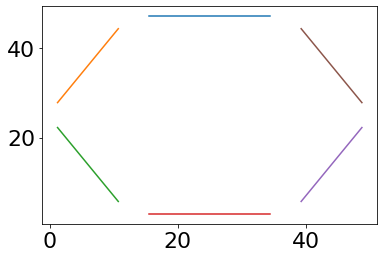

In [4]:
#Setup the communication environment:

#For now, use same channel params
nPL = 5.2
kPL = -20

decorrSH = 2.09  
alpha = 16
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5


#12 remote stations
rad = 22
le=19
center = [25, 25]
def gen_bs(c, r, l,  theta):
    #rotate 90 degrees
    field_center = [-r*np.sin(theta)+c[0], r*np.cos(theta)+c[1]]
    bs1 = [-1*(l/2)*np.sin(-(theta-np.pi/2))+field_center[0], (l/2)*np.cos(-(theta+np.pi/2))+field_center[1]]
    bs2 = [-1*(l/2)*np.sin(-(theta+np.pi/2))+field_center[0], (l/2)*np.cos(-(theta-np.pi/2))+field_center[1]]
    return bs1, bs2

qBase = []
for i in range(6):
    theta = i*2*np.pi/6
    b1, b2 = gen_bs(center, rad, le, theta)
    print(b1, b2)
    qBase.append(b1)
    qBase.append(b2)
    plt.plot([b1[0], b2[0]],[b1[1], b2[1]])
qBase = np.array(qBase)

sub_regions = [[40,10, 50,40],
               [16,0, 50, 22],
               [16,0, 28, 0],
               [40, 10, 10,0],
               [50, 34, 28, 0],
               [50, 34, 50, 22]]


x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]


cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]



#res = 2/decorrMP
res = 10
n = 6
p_th = 0.5

#Polling System Setup
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
print(beta)
els = [0.15/beta, 0.15/beta, 0.15/beta, 0.15/beta, 0.15/beta, 0.15/beta]
print(els)

In [5]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing genera

In [6]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs

print(prob_pred_con)

Drawing 300 samples from Channel 1
Completed PredictedChannel 1
Drawing 300 samples from Channel 2
Completed PredictedChannel 2
Drawing 448 samples from Channel 3
Completed PredictedChannel 3
Drawing 448 samples from Channel 4
Completed PredictedChannel 4
Drawing 448 samples from Channel 5
Completed PredictedChannel 5
Drawing 448 samples from Channel 6
Completed PredictedChannel 6
Drawing 300 samples from Channel 7
Completed PredictedChannel 7
Drawing 300 samples from Channel 8
Completed PredictedChannel 8
Drawing 448 samples from Channel 9
Completed PredictedChannel 9
Drawing 448 samples from Channel 10
Completed PredictedChannel 10
Drawing 448 samples from Channel 11
Completed PredictedChannel 11
Drawing 448 samples from Channel 12
Completed PredictedChannel 12
[0.8564058469475494, 0.7606837606837606, 0.6548856548856549, 0.8120879120879121, 0.8606194690265486, 0.7945007235890015]


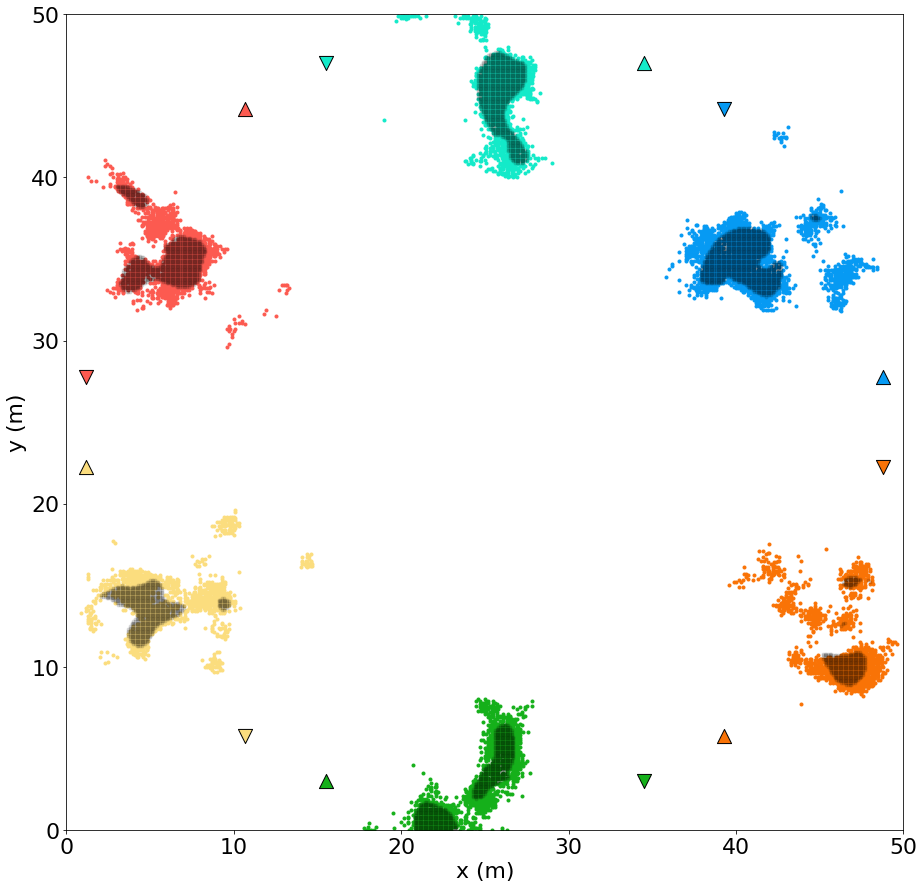

In [7]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [8]:
#setup the delay-tolerant relay system
reload(dtr)
dt_sys = dtr.DTR(pcs, region, els, beta, th=GAMMA_TH, p_th = p_th)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
6 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
8 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
8 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([46.3 12.5])  ([46.5 12.7])  ([46.4 12.7]) Is Interior: False
7 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
10 total subregions


In [9]:
%store dt_sys

Stored 'dt_sys' (DTR)


Total of 60 Permutations to Try
Working on Permutation (0, 1, 2, 3, 4, 5)
Academic license - for non-commercial use only - expires 2022-07-30
Using license file /opt/gurobi912/gurobi.lic
Optimal Solution Improved to 113.83
Working on Permutation (0, 1, 2, 3, 5, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 4, 3, 5)
skiping based on lower bound
Working on Permutation (0, 1, 2, 4, 5, 3)
skiping based on lower bound
Working on Permutation (0, 1, 2, 5, 3, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 5, 4, 3)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 4, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 5, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 2, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 5, 2)
skiping based on lower bound
Working on Permutation (0, 1, 3, 5, 2, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 5, 4, 2)
skiping based on lower bo

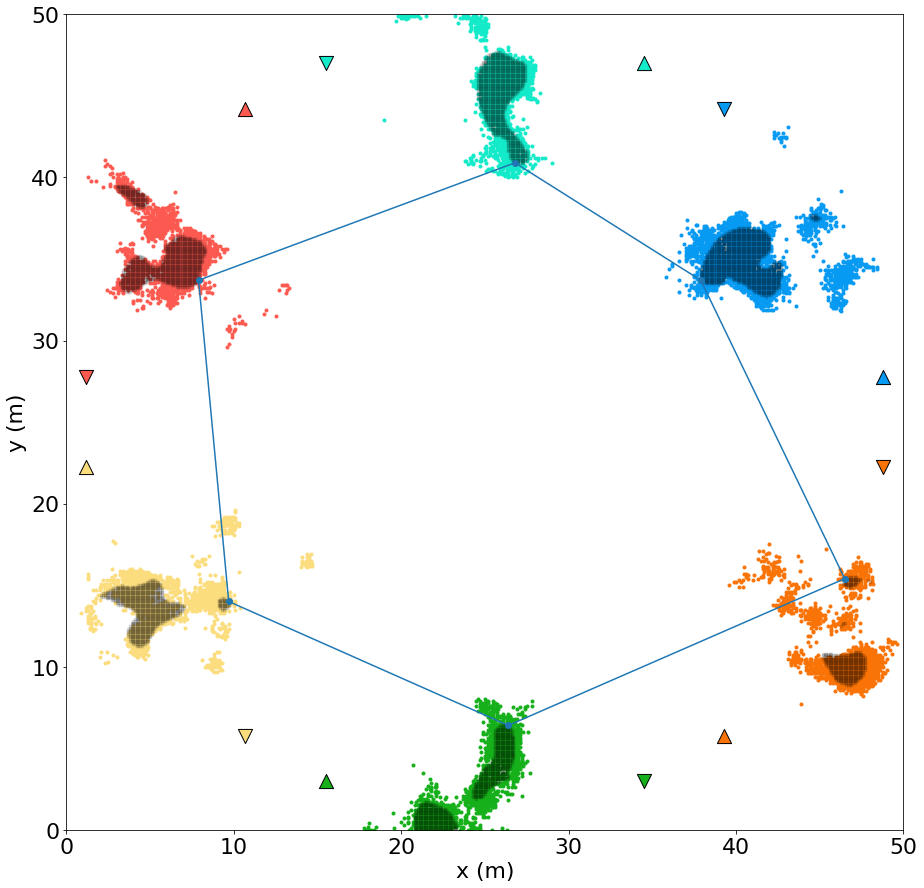

(0, 1, 2, 3, 4, 5)

In [10]:
#Calculate baseline TSPN policy
# import gurobi_solvers as GB
# reload(GB)
# reload(TSPN)
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

reload(sim)
order = list(tspn_argmin[1])
order.append(0)#complete the loop
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.plot(x[order,0], x[order,1], zorder=100)
plt.scatter(x[:,0], x[:,1], zorder = 100)
plt.gca().invert_yaxis()
plt.show()

tspn_argmin[1]

In [11]:
reload(dtr)
reload(sim)

vs=[0.2, 1, 5]
AORPS=[]
for v in vs:
    AORPS.append(sim.calc_AORP(dt_sys, v))

    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 5867.6377
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 5865.4591
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 5865.4591
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 1175.9221
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 1173.3271
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 1173.3168
    model.name="

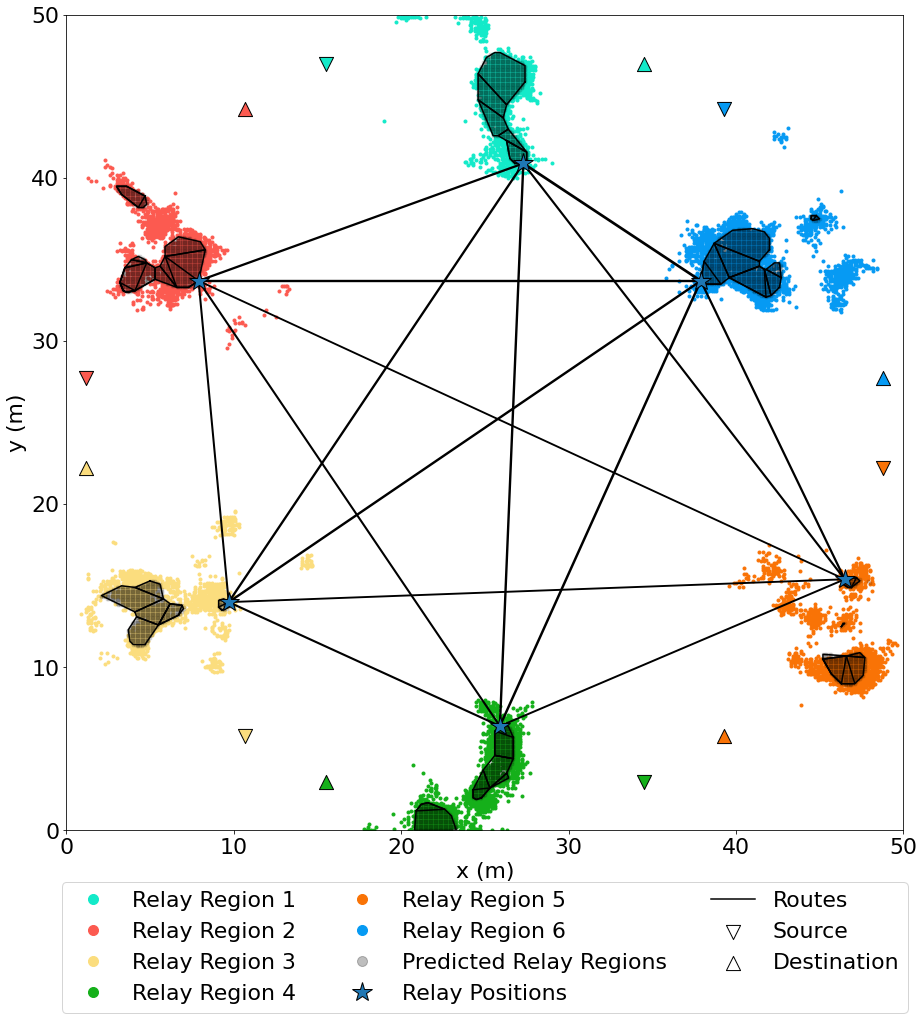

In [12]:
# print(AORPs)
reload(sim)
sim.plot_AORP(dt_sys, AORPS[1], tjcps, pjcps, qBase, region)

In [13]:
# reload(SHOT)
# pi = AORP['pi']
# x = AORP['X']
# S = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         S[i,j] = np.linalg.norm(x[i] - x[j])

# print(pi)
# print(S)
# P, val = SHOT.min_PWD_over_P(pi, S, verbose = False)


In [14]:
%%notify
reload(sim)
TSPNP={'X':x, 'SEQ':tspn_argmin[1]}
hrs = 1
mins = 0
seconds = 0
for i in range(len(vs)):
    v = vs[i]
    print('Velocity = %f'%(v))
    AORP = AORPS[i]
    motion_power = motion.LinearMotionPower(7.2, 0.29, v)
    sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)


Velocity = 0.200000
Theotretical MB serviced: 51840.0
Theoretical Energy Consumption (J): 946.8000000000001
	Th. WT	WT	E (J)	MBS	MBR
AORP	5865.46	591.68	3081.93	31212.00	20566.55
Tab	---	763.40	3048.00	31713.90	20047.40
TSPN	---	678.02	2488.31	36966.85	14856.75
Velocity = 1.000000
Theotretical MB serviced: 51840.0
Theoretical Energy Consumption (J): 3020.3999999999996
	Th. WT	WT	E (J)	MBS	MBR
AORP	1173.32	411.74	7355.22	42492.10	9312.35
Tab	---	395.03	6800.13	43679.85	8142.70
TSPN	---	280.29	5560.27	46376.95	5405.10
Velocity = 5.000000
Theotretical MB serviced: 51840.0
Theoretical Energy Consumption (J): 13388.399999999996
	Th. WT	WT	E (J)	MBS	MBR
AORP	234.89	160.63	19903.28	48966.85	2868.20
Tab	---	136.99	18976.20	49373.55	2392.25
TSPN	---	84.80	16453.38	50485.60	1351.75


<IPython.core.display.Javascript object>

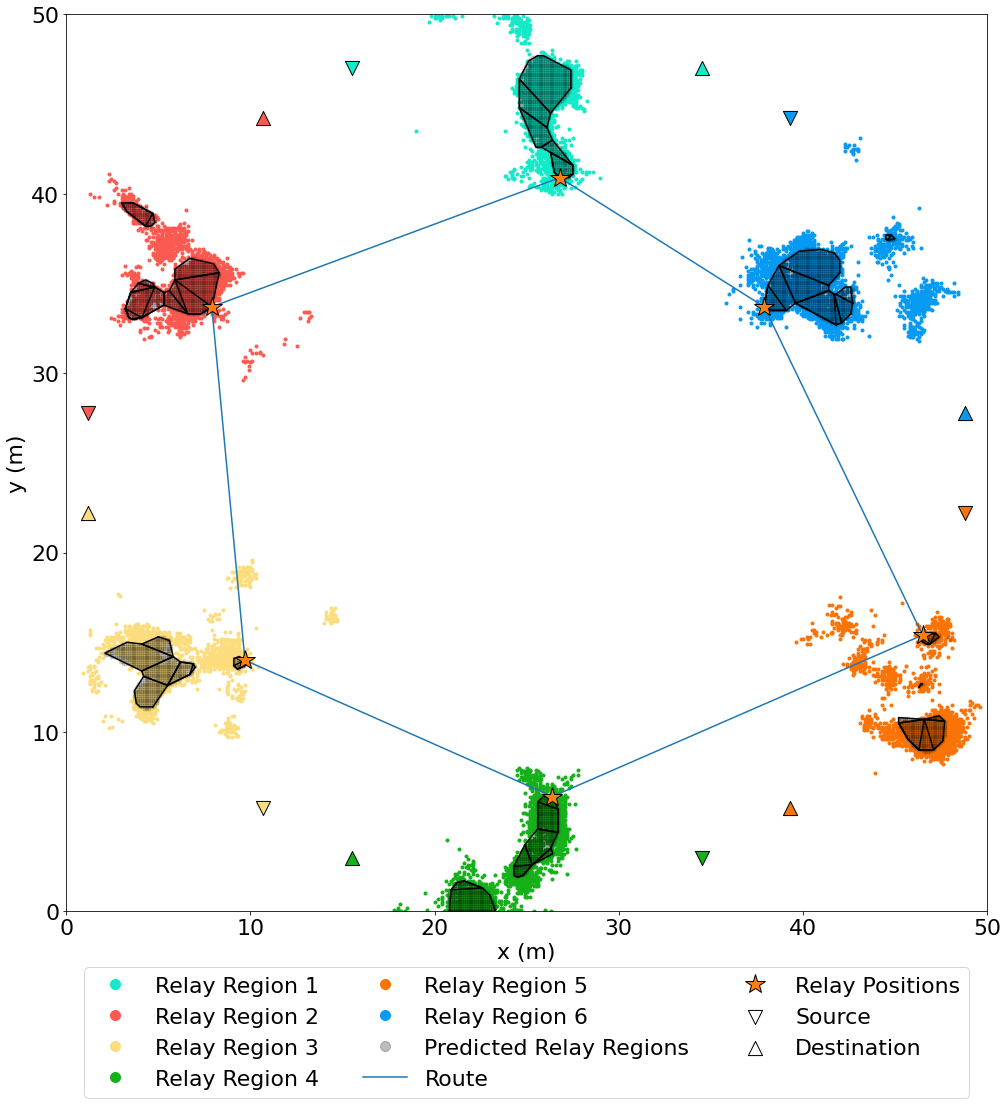

In [15]:
reload(sim)
sim.plot_TSPNP(dt_sys, TSPNP, tjcps, pjcps, qBase, region)
sim.save_plt('six_star_TSPNP.png')

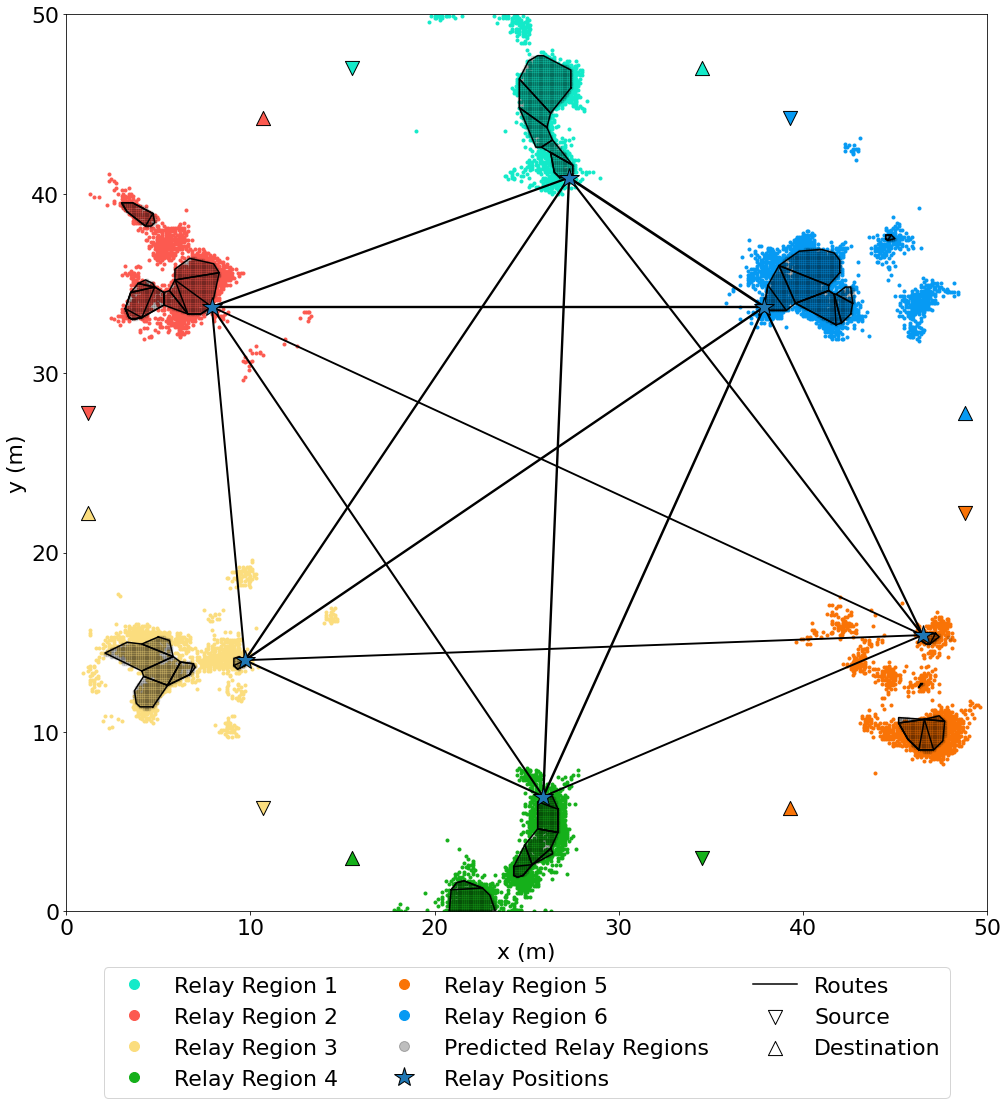

In [16]:
reload(sim)
sim.plot_AORP(dt_sys, AORPS[0], tjcps, pjcps, qBase, region)
sim.save_plt('six_star_AORP_v02.png')

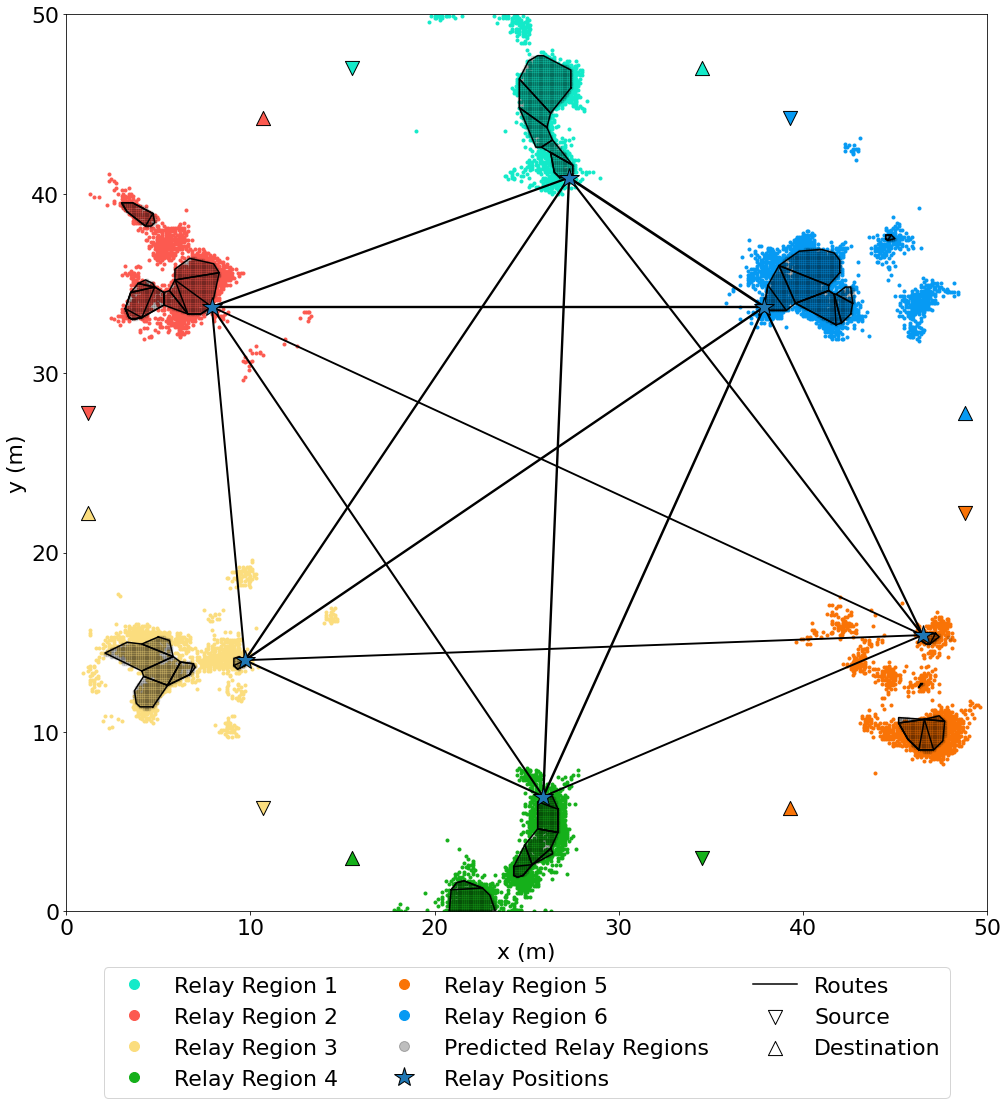

In [17]:
reload(sim)
sim.plot_AORP(dt_sys, AORPS[1], tjcps, pjcps, qBase, region)
sim.save_plt('six_star_AORP_v1.png')

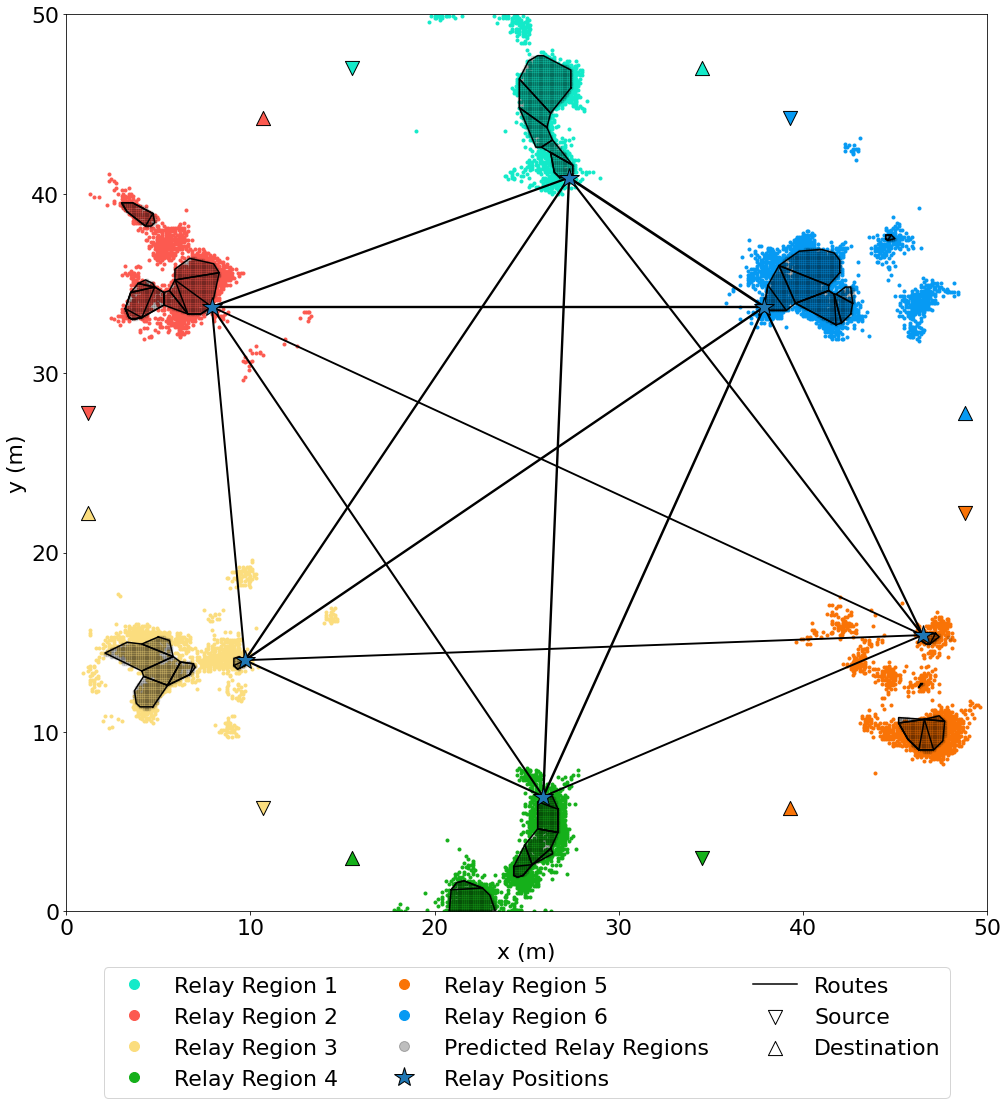

In [18]:
reload(sim)
sim.plot_AORP(dt_sys, AORPS[2], tjcps, pjcps, qBase, region)
sim.save_plt('six_star_AORP_v5.png')

In [19]:
%%notify
#####################
# Now for the same system, re-run, but for different system lambdas
#els2 = [0.15/beta, 0.15/beta, 0.15/beta, 0.15/beta, 0.15/beta, 0.15/beta]
els2 = [0.01/beta, 0.15/beta, 0.01/beta, 0.15/beta, 0.01/beta, 0.15/beta]
dt_sys.ps = PS.PollingSystem(els2, beta)

AORPS2=[]
for v in vs:
    AORPS2.append(sim.calc_AORP(dt_sys, v))
    print('Velocity = %f'%(v))
    AORP = AORPS2[-1]
    motion_power = motion.LinearMotionPower(7.2, 0.29, v)
    sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)


    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 796.8282
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 795.6436
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 795.6440
Velocity = 0.200000
Theotretical MB serviced: 27648.0
Theoretical Energy Consumption (J): 3411.3600000000006
	Th. WT	WT	E (J)	MBS	MBR
AORP	795.64	476.80	4021.70	22562.70	5096.45
Tab	---	474.21	3931.57	23220.40	4454.45
TSPN	---	419.74	3844.65	23655.50	3996.50
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 159.8686
    model.name="unknown";
      - termination condition: optimal
      - message from sol

<IPython.core.display.Javascript object>

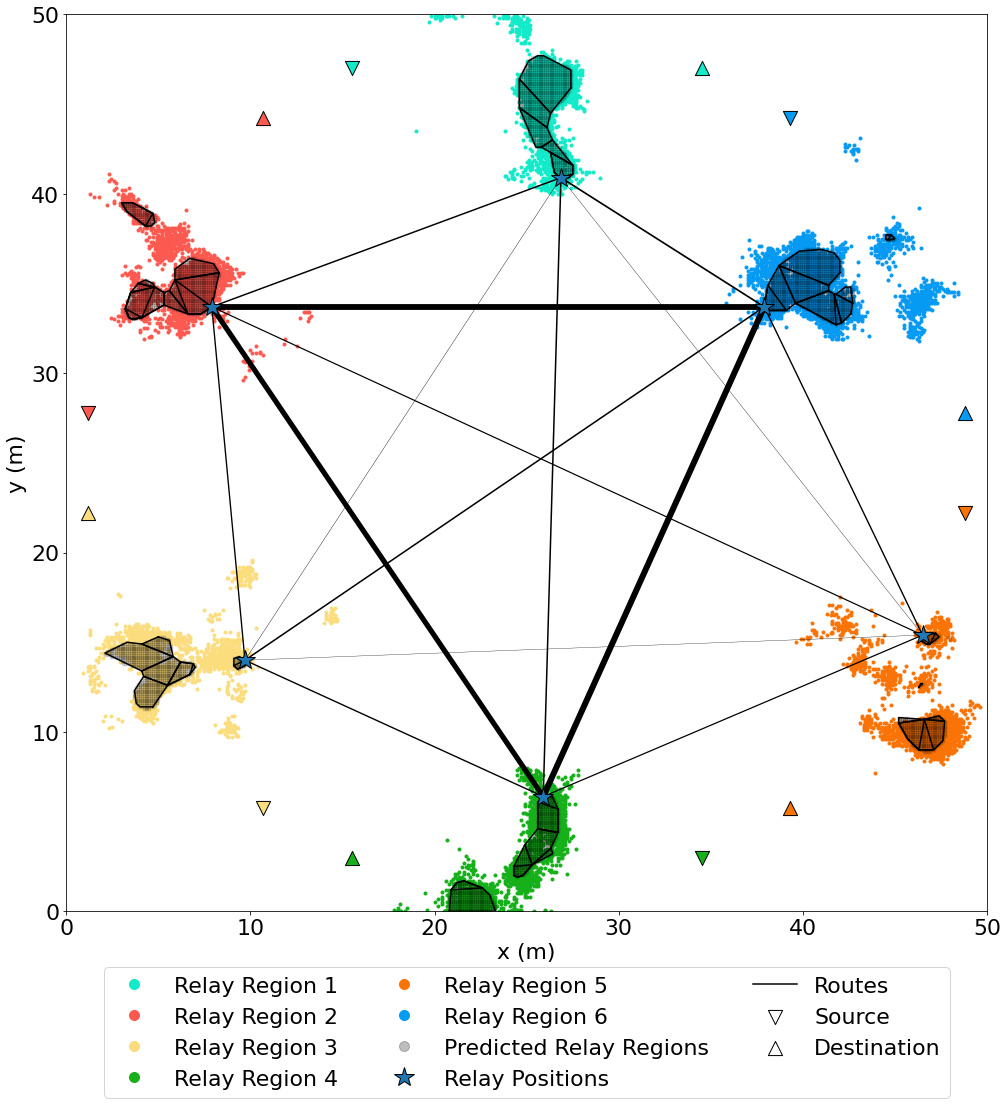

In [20]:
reload(sim)
sim.plot_AORP(dt_sys, AORPS2[0], tjcps, pjcps, qBase, region)
sim.save_plt('six_star_AORP_v02_L2.png')

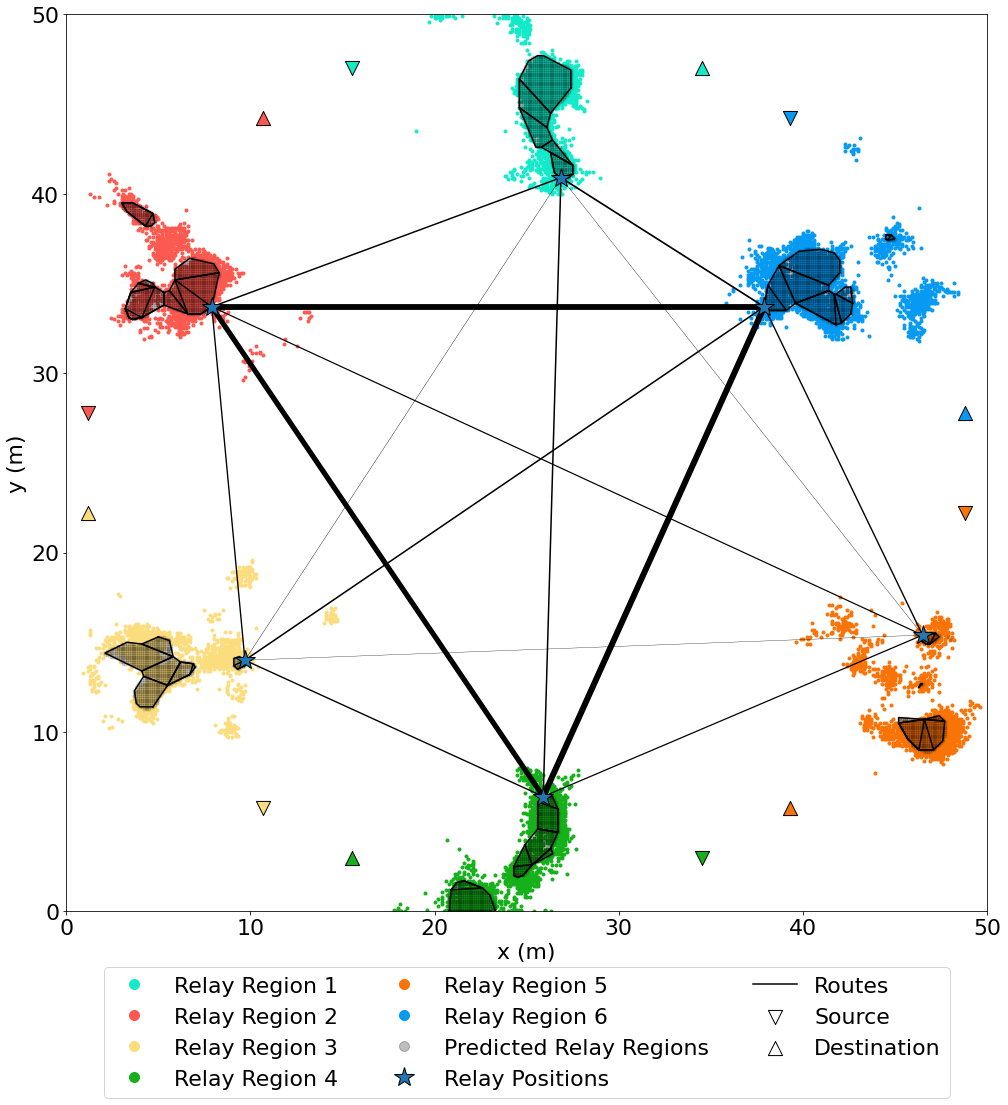

In [21]:
reload(sim)
sim.plot_AORP(dt_sys, AORPS2[1], tjcps, pjcps, qBase, region)
sim.save_plt('six_star_AORP_v1_L2.png')

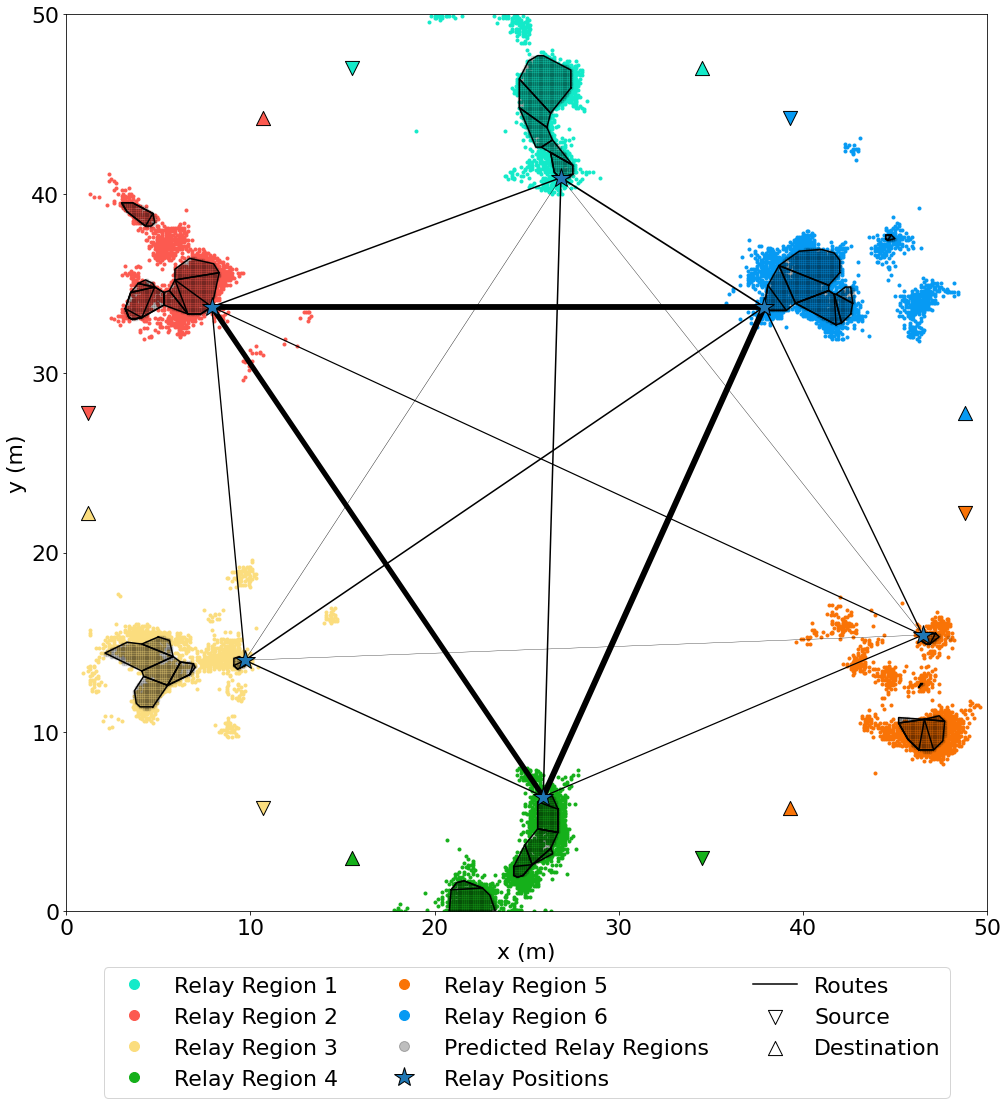

In [22]:
reload(sim)
sim.plot_AORP(dt_sys, AORPS2[2], tjcps, pjcps, qBase, region)
sim.save_plt('six_star_AORP_v5_L2.png')

In [23]:
%%notify
#####################
# Now for the same system, re-run, but for different system lambdas
els3 = [0.15/beta, 0.15/beta, 0.15/beta, 0.01/beta, 0.01/beta, 0.01/beta]
dt_sys.ps = PS.PollingSystem(els3, beta)

AORPS3=[]
for v in vs:
    AORPS3.append(sim.calc_AORP(dt_sys, v))
    


    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 738.4666
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 736.1356
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 736.1356
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 147.3019
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 147.2502
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
Optimized Waiting Time: 147.2502
    model.name="unknow

<IPython.core.display.Javascript object>

In [24]:
reload(sim)

for i in range(len(vs)):
    v = vs[i]
    AORP = AORPS3[i]
    print('Velocity = %f'%(v))
    motion_power = motion.LinearMotionPower(7.2, 0.29, v)
    sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)

Velocity = 0.200000
Theotretical MB serviced: 27648.0
Theoretical Energy Consumption (J): 3411.3600000000006
	Th. WT	WT	E (J)	MBS	MBR
AORP	736.14	445.29	3953.86	22917.10	4758.25
Tab	---	392.77	3842.66	23790.25	3890.65
TSPN	---	426.11	3796.81	24021.25	3631.80
Velocity = 1.000000
Theotretical MB serviced: 27648.0
Theoretical Energy Consumption (J): 14194.08
	Th. WT	WT	E (J)	MBS	MBR
AORP	147.25	136.68	14785.01	26475.70	1131.50
Tab	---	107.00	14669.42	26770.35	872.95
TSPN	---	92.40	14598.74	26877.20	796.85
Velocity = 5.000000
Theotretical MB serviced: 27648.0
Theoretical Energy Consumption (J): 68107.68
	Th. WT	WT	E (J)	MBS	MBR
AORP	29.47	29.64	68570.00	27461.45	231.70
Tab	---	22.28	68618.93	27449.90	168.60
TSPN	---	18.78	68412.80	27525.20	150.75


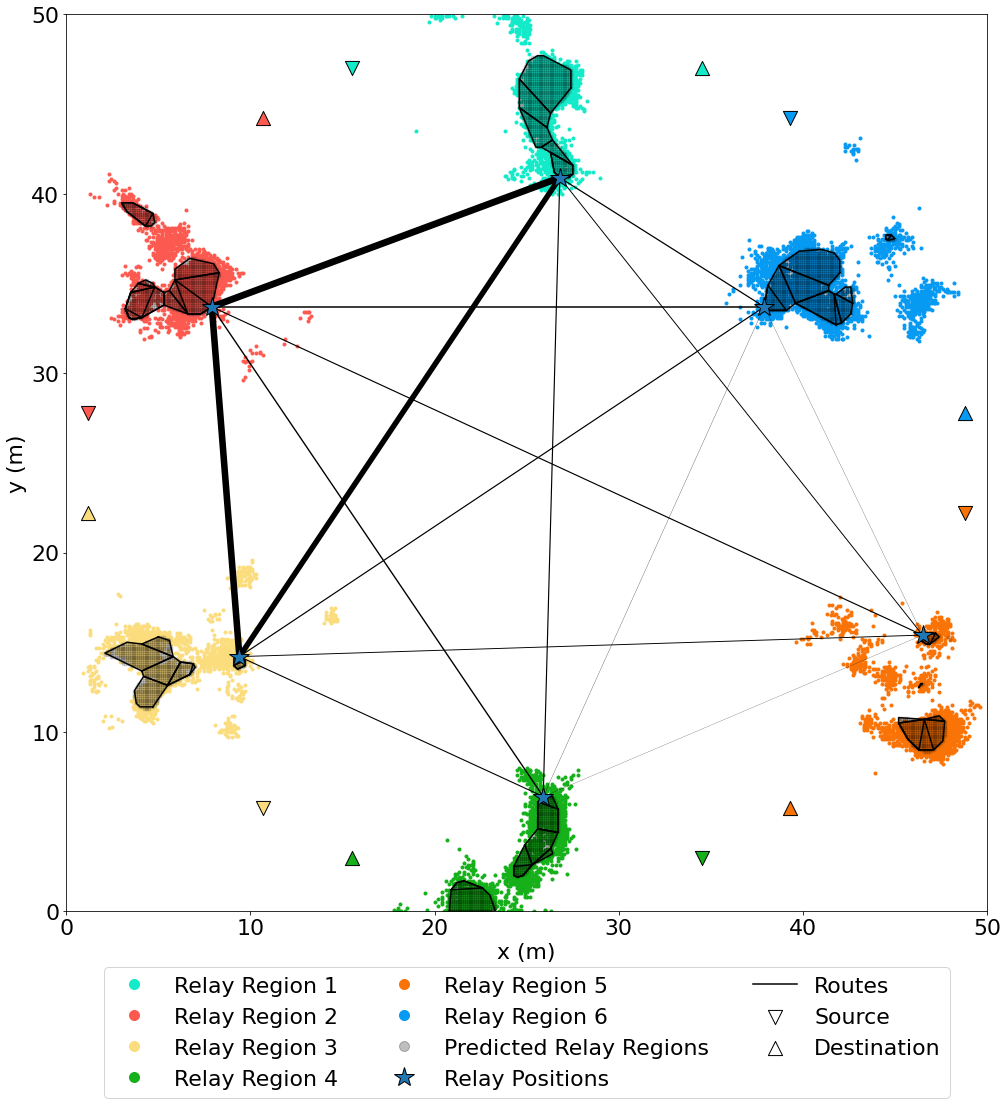

In [25]:
reload(sim)
sim.plot_AORP(dt_sys, AORPS3[0], tjcps, pjcps, qBase, region)
sim.save_plt('six_star_AORP_v02_L3.png')

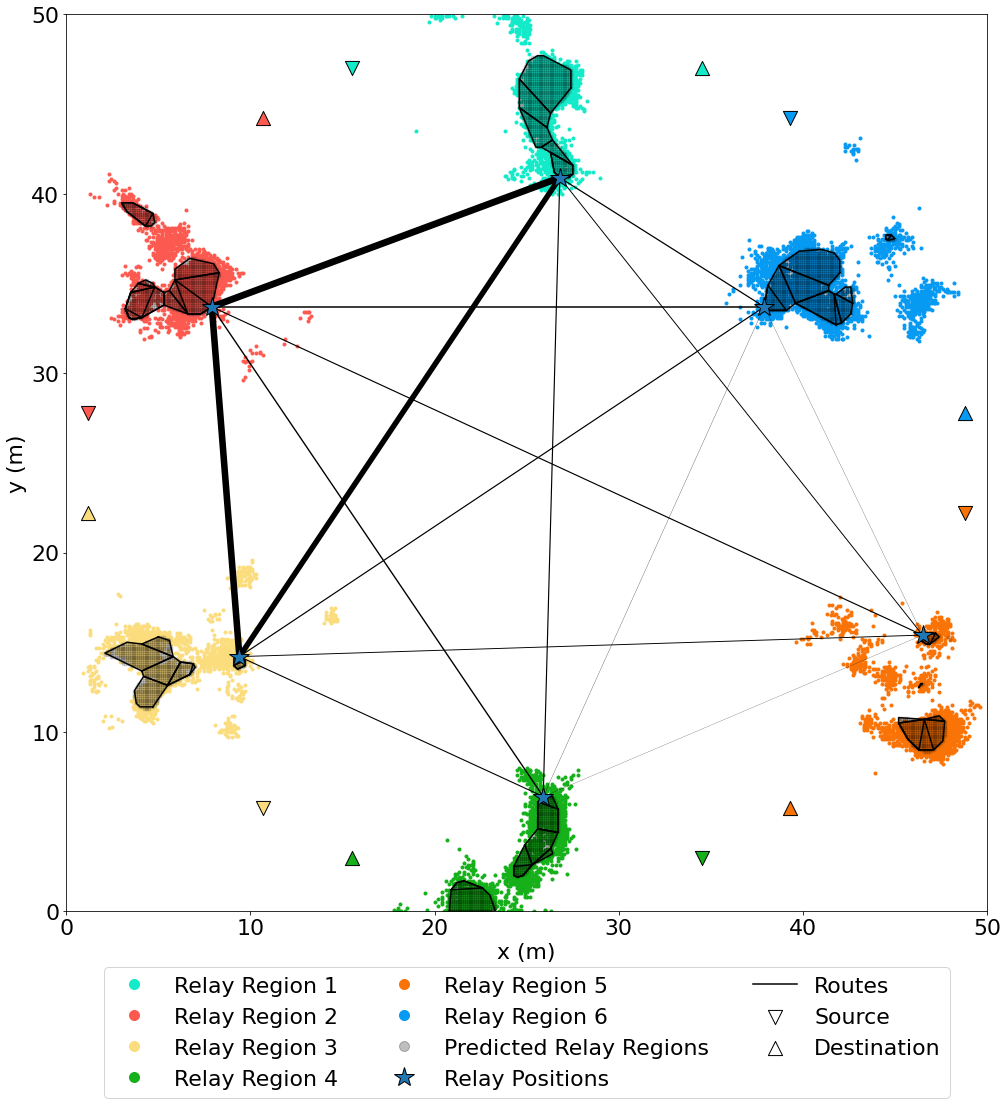

In [26]:
reload(sim)
sim.plot_AORP(dt_sys, AORPS3[1], tjcps, pjcps, qBase, region)
sim.save_plt('six_star_AORP_v1_L3.png')

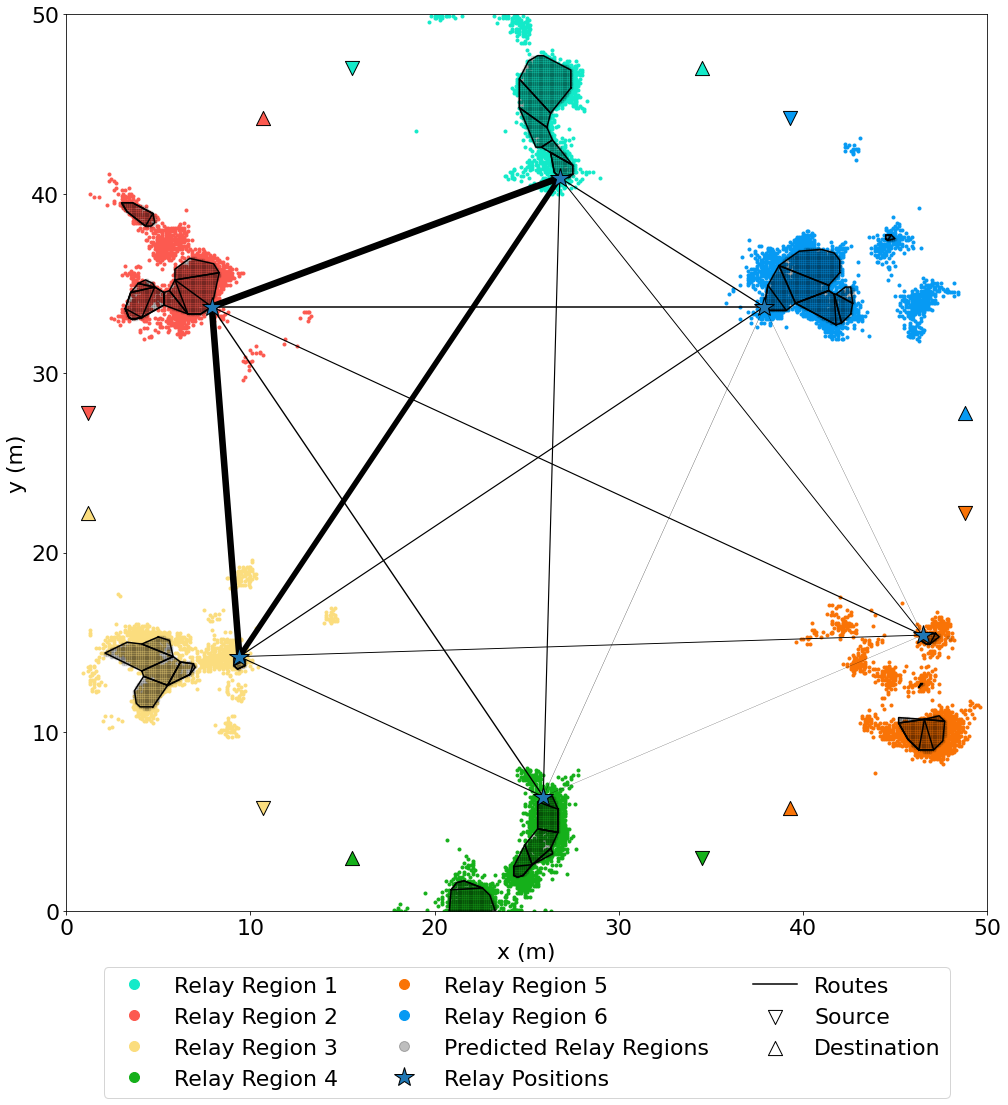

In [27]:
reload(sim)
sim.plot_AORP(dt_sys, AORPS3[2], tjcps, pjcps, qBase, region)
sim.save_plt('six_star_AORP_v5_L3.png')